# Using Lime with Pytorch

LIME creates explanations by generating a new dataset of random perturbations (with their respective predictions) around the instance being explained and then fitting a weighted local surrogate model. This local model is usually a simpler model with intrinsic interpretability such as a linear regression model. For more details about the basics behind LIME, I recommend you to check this short tutorial. 


For the case of image classification, LIME generates explanations with the following steps:

### Step 1:
Generate random perturbations for input image
For the case of images, LIME generates perturbations by turning on and off some of the super-pixels in the image. The following script uses the quick-shift segmentation algorithm to compute the super-pixels in the image. In addition, it generates an array of 150 perturbations where each perturbation is a vector with zeros and ones that represent whether the super-pixel is on or off.


### Step 2

The following script uses the inceptionV3_model to predict the class of each of the perturbed images. The shape of the predictions is (150,1000) which means that for each of the 150 images, we get the probability of belonging to the 1,000 classes in InceptionV3. From these 1,000 classes we will use only the Labrador class in further steps since it is the prediction we want to explain. In this example, 150 perturbations were used. However, for real applications, a larger number of perturbations will produce more reliable


We use a distance metric to evaluate how far is each perturbation from the original image. The original image is just a perturbation with all the super-pixels active (all elements in one). Given that the perturbations are multidimensional vectors, the cosine distance is a metric that can be used for this purpose. After the cosine distance has been computed, a kernel function is used to translate such distance to a value between zero and one (a weight). At the end of this process we have a weight (importance) for each perturbation in the dataset.


We fit a weighted linear model using the information obtained in the previous steps. We get a coefficient for each super-pixel in the image that represents how strong is the effect of the super-pixel in the prediction of Labrador.

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F


Load our test image and see how it looks.

In [27]:
!pip install lime


     |████████████████████████████████| 276kB 5.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=b2d3466e5e535333532d160197ce79142de08b421913780e64b260684e22af86
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [28]:
import lime

In [38]:
!wget "https://i.insider.com/5ef54cb61918242cfb4ec653?width=1300&format=jpeg&auto=webp" -O dog2.png

--2020-12-09 13:15:10--  https://i.insider.com/5ef54cb61918242cfb4ec653?width=1300&format=jpeg&auto=webp
Resolving i.insider.com (i.insider.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to i.insider.com (i.insider.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149927 (146K) [image/jpeg]
Saving to: ‘dog2.png’

dog2.png            100%[===================>] 146.41K  --.-KB/s    in 0.03s   

2020-12-09 13:15:10 (5.03 MB/s) - ‘dog2.png’ saved [149927/149927]



In [18]:

!wget https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/dogs.png

!wget https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/imagenet_class_index.json

--2020-12-09 13:10:04--  https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.003s  

2020-12-09 13:10:04 (10.1 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



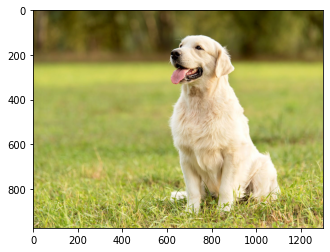

In [39]:

f = "/content/dog2.png"
img = Image.open(f).convert('RGB') 
        
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [40]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet50 available in Pytorch.

In [41]:
model = models.inception_v3(pretrained=True)

Load label texts for ImageNet predictions so we know what model is predicting

In [42]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('/content/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

Get the predicition for our image.

In [43]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [44]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.976074, 207, 'golden_retriever'),
 (0.012522464, 257, 'Great_Pyrenees'),
 (0.005540142, 222, 'kuvasz'),
 (0.0052163773, 208, 'Labrador_retriever'),
 (0.0004012764, 212, 'English_setter'))

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [45]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [46]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [47]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

207

Import lime and create explanation for this prediciton.

In [48]:
from lime import lime_image

In [49]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

Let's use mask on image and see the areas that are encouraging the top prediction.

In [50]:
from skimage.segmentation import mark_boundaries

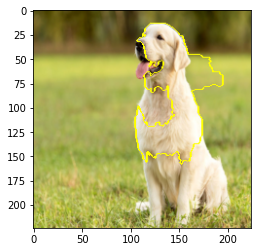

In [52]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

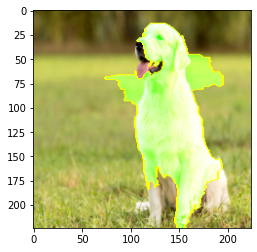

In [53]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)